<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220726.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [94]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 
import os 
import re 

from functools import reduce
from collections import ChainMap, defaultdict, Counter

# customer analysis

In [3]:
os.listdir()

['.config',
 'shops.csv',
 'listings.csv',
 'retail_data_response.csv',
 'item_categories.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_submission.csv',
 'rfm_test.csv',
 'sales_train.csv',
 'online_retail_II.xlsx',
 'retail_data_transactions.csv',
 '.Rhistory',
 'ecommerce-data.csv',
 'test.csv',
 'items.csv',
 'sample_data']

In [71]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [72]:
#['_'.join(a) for a in re.split('(?=[A-Z])', b) for b in df.columns]
['_'.join([a.lower() for a in re.split(r'(?=[A-Z])', b[0].lower()+b[1:])]) for b in df.columns]

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_i_d',
 'country']

In [73]:
df.columns = [a.lower() for a in df.columns]
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [74]:
df = df[(~df.invoiceno.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [75]:
df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df['date'] = df['invoicedate'].to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['rev'] = df['quantity'] * df['unitprice']
df = df[['customerid', 'date', 'month', 'rev']].rename(columns = {'customerid':'id'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,12346.0,2011-01-18,2011-01-01,77183.60
1,12747.0,2010-12-05,2010-12-01,358.56
2,12747.0,2010-12-13,2010-12-01,347.71
3,12747.0,2011-01-20,2011-01-01,303.04
4,12747.0,2011-03-01,2011-03-01,310.78


In [76]:
df = df.sort_values(['id', 'month'], ascending = [1,0])
df.head()

,id,date,month,rev
0,12346.0,2011-01-18,2011-01-01,77183.60
11,12747.0,2011-12-07,2011-12-01,438.50
10,12747.0,2011-11-17,2011-11-01,312.73
9,12747.0,2011-10-04,2011-10-01,675.38
8,12747.0,2011-08-22,2011-08-01,301.70


In [107]:
list_pu = df.groupby(['id', 'month'])['rev'].sum().reset_index().sort_values(['id', 'month'])
list_npu = list_pu.groupby(['id']).first().reset_index()
list_mon = list_npu['month'].sort_values().unique()

In [109]:
for mon in list_mon :
  
  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['rev'].count().reset_index().rename(columns = {'rev':'pu'})
  temp = temp.sort_values(['month'], ascending = True)
  temp = temp.assign(nru_month = mon, 
              num = temp['month'].rank(),
              ratio = lambda x : round(x['pu']/x['pu'].max(),2)
              )
  temp = temp.reindex(columns = ['nru_month', 'month','num', 'pu', 'ratio'])

  if mon == list_mon[0] :
    res = temp
  else :
    res = pd.concat([res, temp], axis = 0)

res['nru_month'] = res['nru_month'].astype(str)
res.sort_values(['nru_month', 'num'])

,nru_month,month,num,pu,ratio
0,2010-12-01,2010-12-01,1.0,815,1.00
1,2010-12-01,2011-01-01,2.0,289,0.35
2,2010-12-01,2011-02-01,3.0,263,0.32
3,2010-12-01,2011-03-01,4.0,304,0.37
4,2010-12-01,2011-04-01,5.0,293,0.36
...,...,...,...,...,...
1,2011-10-01,2011-11-01,2.0,79,0.24
2,2011-10-01,2011-12-01,3.0,36,0.11
0,2011-11-01,2011-11-01,1.0,298,1.00
1,2011-11-01,2011-12-01,2.0,35,0.12


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


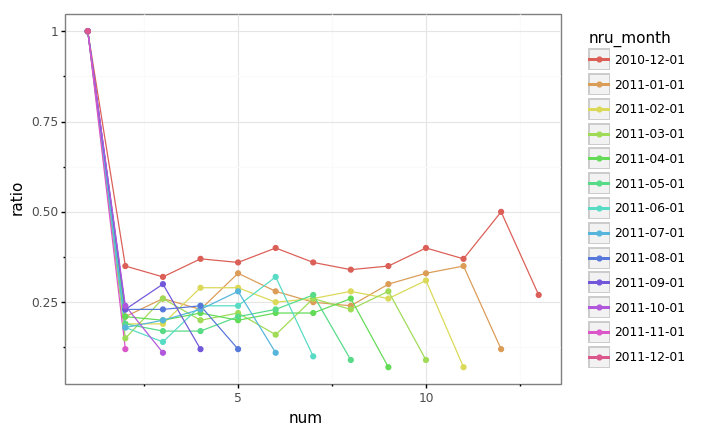

<ggplot: (8775686190917)>

In [110]:
(
    ggplot(res, aes('num', 'ratio', color = 'nru_month')) +
    gg.geom_line() +
    gg.geom_point() +
    gg.theme_bw()
)

# iterator

In [111]:
mat = [list('ABC'), list('DEF'), list('HIG')]
for r, rows in enumerate(mat) :
  for c, letter in enumerate(mat) :
    print(f'({r},{c}) - {letter}')

(0,0) - ['A', 'B', 'C']
(0,1) - ['D', 'E', 'F']
(0,2) - ['H', 'I', 'G']
(1,0) - ['A', 'B', 'C']
(1,1) - ['D', 'E', 'F']
(1,2) - ['H', 'I', 'G']
(2,0) - ['A', 'B', 'C']
(2,1) - ['D', 'E', 'F']
(2,2) - ['H', 'I', 'G']


In [112]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [113]:
for key in list(users[0].keys()) :

  if key == list(users[0].keys())[0] :

    res = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')

  else :

    res = np.c_[res, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')]

res

array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [114]:
[eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())]

[['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 ['M', 'F', 'M', 'F', 'F'],
 [73, 29, 51, 32, 42]]

In [115]:
portfolio = [
    ('GOOG', 100, 490.1),
    ('IBM', 50, 91.1),
    ('CAT', 150, 83.44),
    ('IBM', 100, 45.23),
    ('GOOG', 75, 572.45),
    ('AA', 50, 23.15)
]
portfolio

[('GOOG', 100, 490.1),
 ('IBM', 50, 91.1),
 ('CAT', 150, 83.44),
 ('IBM', 100, 45.23),
 ('GOOG', 75, 572.45),
 ('AA', 50, 23.15)]

In [116]:
a = Counter()
for com, share, price in portfolio :
  a[com] += share 
a

Counter({'AA': 50, 'CAT': 150, 'GOOG': 175, 'IBM': 150})

In [117]:
b = defaultdict(list)
for com, share, price in portfolio :
  b[com].append((share, price))
b

defaultdict(list,
            {'AA': [(50, 23.15)],
             'CAT': [(150, 83.44)],
             'GOOG': [(100, 490.1), (75, 572.45)],
             'IBM': [(50, 91.1), (100, 45.23)]})